# Show some UNet deconvolution output
v>=16dec25

In [36]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../code')) # path to your source code
sys.path.insert(0, module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
from model import *
from galaxy_img_utils import *

In [38]:
from utils_plot import *

In [39]:
config_file = "./config_DeconvNoisy_COSMOS_4nb.yaml"

with open(config_file, "r") as config:
    settings_dict = yaml.safe_load(config)
args = SimpleNamespace(**settings_dict)

In [40]:
args

namespace(fov_pixels=48,
          pixel_scale=0.03,
          upsample=4,
          atmos_fwhm=0.4,
          atmos_e=0.01,
          sigma_defocus=0.1,
          sigma_opt_psf=0.07,
          min_shear=0.01,
          max_shear=0.05,
          opt_obs_min=0.1,
          opt_obs_width=0.4,
          lam_ov_d_min=0.017,
          lam_ov_d_width=0.007,
          sigma_noise_max=1.0,
          archi='Unet-Full',
          pool_window=2,
          num_blocks=2,
          num_kernels=64,
          num_channels=1,
          kernel_size=3,
          padding=1,
          bias=True,
          num_enc_conv=2,
          num_mid_conv=2,
          num_dec_conv=2,
          input_cosmos_dir='/lustre/fsn1/projects/rech/ixh/ufd72rp/',
          input_data_dir='../',
          input_gal_file_list='list_gal_files_48pix.json',
          models_root_dir='../models/',
          seed=116122025,
          num_workers=10,
          checkpoint_file='/Unet-Full_last_state.pth',
          history_loss_cpt_file=

In [41]:
# device cpu/gpu...
args.device = (
    torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)

In [67]:
reset_randoms(args)

In [68]:
def load_Unet(model_dir):
    model_checkpoint_file = model_dir + "Unet-Full_best_state.pth"
    model = UNet(args)
    model.to(args.device);
    checkpoint = torch.load(model_checkpoint_file)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    return model

In [69]:
def get_gt_img(args):
    #load
    gal_orig = galsim.fits.read("./cosmos_exa/gal_ex_Unet_deconv.fits") # original galaxy image
    psf      = galsim.fits.read("./cosmos_exa/psf_ex_Unet_deconv.fits") # original HST PSF
    noise    = galsim.fits.read("./cosmos_exa/noise_ex_Unet_deconv.fits") # original noise image
    with open("./cosmos_exa/info__ex_Unet_deconv.json", "r") as f:
        info = json.load(f)
        pixel_scale = info["pixel_scale"]  # original pixel_scale
        var = info['var']                  # original noise variance



    
    psf.array = psf.array/psf.array.sum() # adjust flux to 1.0 for HST PSF
    psf_hst   = galsim.InterpolatedImage(psf)
    gal_rg    = galsim.RealGalaxy((gal_orig,psf,noise,pixel_scale,var))

    gal = get_Galaxy_img(
        gal_rg,
        psf_hst,
        gal_g=args.gal_g,
        gal_beta=args.gal_beta,
        theta=args.gal_theta,
        gal_mu=args.gal_mu,
        dx= args.gal_dx,
        dy= args.gal_dy,
        fov_pixels=args.fov_pixels,
        pixel_scale=args.pixel_scale,
        upsample=args.upsample,
    )

    return gal



In [70]:
def get_new_psf(args,atmos_fwhm,skip_atmos=False):
    return get_Obs_PSF(
        args.lam_over_diam,
        args.opt_defocus,
        args.opt_c1,
        args.opt_c2,
        args.opt_a1,
        args.opt_a2,
        args.opt_obscuration,
        atmos_fwhm,
        args.atmos_e,
        args.atmos_beta,
        args.spher,
        args.trefoil1,
        args.trefoil2,
        0,
        0,
        args.fov_pixels,
        args.pixel_scale,
        args.upsample,
    skip_atmos)


In [71]:
def get_obs_img(gal,psf_obs,sigma):
    # sigma in [0, args.sigma_noise_max]
    assert sigma>=0 and sigma<= args.sigma_noise_max, f"sigma is out of range [0,{args.sigma_noise_max}]"
    # Convolution with the new PSF
    conv = ifftshift(ifft2(fft2(psf_obs.clone()) * fft2(gal.clone()))).real  
    
    
    # Downsample images to desired pixel scale.
    # avoid conv, psf down_scaling as there are only intermediate steps useful for debug
    gt_full = gal.clone()
    gt  = down_sample(gt_full, args.upsample)
    conv = down_sample(conv.clone(), args.upsample)

    # Add noise
    obs = conv + torch.normal(
        mean=torch.zeros_like(conv), std=sigma * torch.ones_like(conv)
    )
    
    return gt, obs

# Plot

In [72]:
def make_imgs(args,gal,atmos_fwhm,sigma):
    psf_optics = get_new_psf(args,atmos_fwhm, skip_atmos=True) # new psf optics fixed only

    psf_new = get_new_psf(args,atmos_fwhm) # new psf (optics fixed, + atmosp)    
    gt, obs = get_obs_img(gal,psf_new,sigma) # ground truth and obsveed (noisy + convolved)

    # deco
    obs = obs.to(args.device)
    with torch.no_grad():
        output = args.model(obs.unsqueeze(0).unsqueeze(0))
    
    gt_img = gt.cpu().numpy().squeeze()
    obs_img = obs.cpu().numpy().squeeze()
    deconv_img = output.cpu().numpy().squeeze()

    #psnr
    psnr_in = psnr(obs_img,gt_img)
    psnr_deconv = psnr(deconv_img,gt_img)
    
    return gt_img,obs_img,deconv_img, psnr_in, psnr_deconv, psf_optics

In [73]:
# 48x48 pix 40,000 train fwhm_max=0.4, sigma_lax =1.0
model_dir = args.models_root_dir + "/"+ "Unet_cosmo_atm0d4_sigma1d0_40000train_64kernels_2blocks_MSE" +"/"
args.model = load_Unet(model_dir)


In [74]:
model_dir

'../models//Unet_cosmo_atm0d4_sigma1d0_40000train_64kernels_2blocks_MSE/'

In [75]:
# default values used for optical and other params EXCEPT atmosperic fwhm

#optics 1
args.lam_over_diam= 0.024
args.opt_defocus = -0.072
args.opt_c1 = 0.177
args.opt_c2 = -0.027
args.opt_a1 = 0.016
args.opt_a2 = 0.005
args.opt_obscuration = 0.111
args.spher = 0.056
args.trefoil1 = 0.028
args.trefoil2 = 0.001
#Kolmogorov (non FWHM)
args.atmos_e = 0.021
args.atmos_beta = 0.276



# Galaxy 
args.gal_g = 0.02 # Shear
args.gal_beta = 0. # Shear
args.gal_mu = 1.0 # Magnification
args.gal_theta = 0.0 # rotation
args.gal_dx = 0.0     # dx
args.gal_dy = 0.0     #dx

In [76]:
gal =  get_gt_img(args)

In [77]:
fwhm_range = np.array([0.0001, 0.05, 0.2 , 0.4])
sigma_range = [0.0, 0.1,0.5,1.0]

Text(0.5, 1.1, 'zoom:6.00')

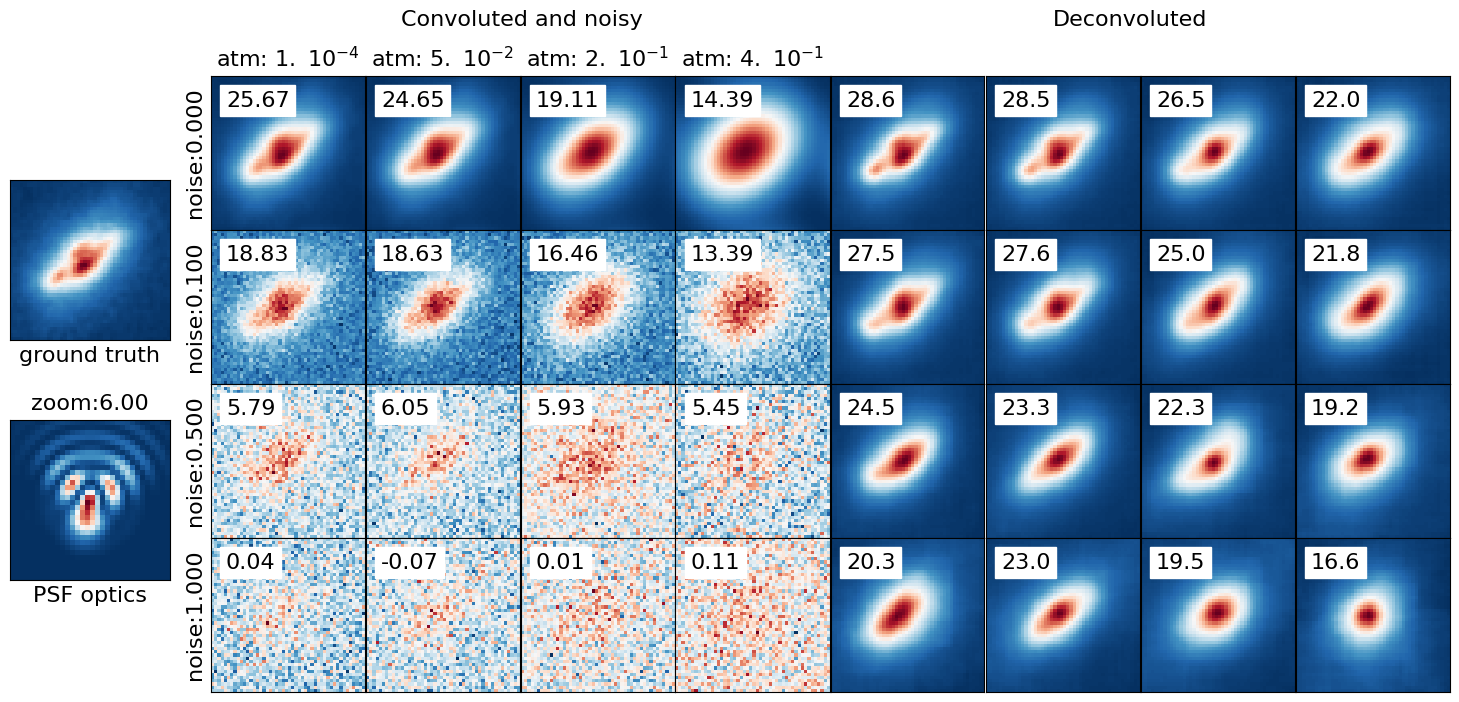

In [78]:
cmap = 'RdBu_r'
fig,axs = plt.subplots(4,8,figsize=(8*2,4*2))
for idxs, sigma in enumerate(sigma_range):
    for idxf, atmos_fwhm in enumerate(fwhm_range):
        gt_img,obs_img,deconv_img, psnr_in, psnr_deconv, psf_optics = make_imgs(args,gal,atmos_fwhm,sigma)
        n_psf_pix_full = psf_optics.squeeze().shape[0]
        axs[idxs,idxf].imshow(obs_img,cmap=cmap)
        axs[idxs,idxf].text(0.1,0.8,f'{psnr_in:.2f}',backgroundcolor="white",
                               transform=axs[idxs,idxf].transAxes)
        axs[idxs,idxf+len(fwhm_range)].imshow(deconv_img,cmap=cmap)
        axs[idxs,idxf+len(fwhm_range)].text(0.1,0.8,f'{psnr_deconv:.1f}',backgroundcolor="white",
                                               transform=axs[idxs,idxf+len(fwhm_range)].transAxes)
        if idxs==0:
            scientific_notation = f"{atmos_fwhm:.1e}"  # "4.0e-01"
            base, exponent = scientific_notation.split('e')
            exponent = int(exponent)
            base = base.replace('.', '')[:1]  # "4"
            latex_notation = f"${base}.\  10^{{{exponent}}}$"
            #axs[idxs,idxf].set_title(f"atm:{atmos_fwhm:.1e}")
            axs[idxs, idxf].set_title(f"atm: {latex_notation}")

        if idxf==0:
            axs[idxs,idxf].set_ylabel(f"noise:{sigma:.3f}")
axs=axs.ravel()
for ax in axs:
    ax.set(xticks=[],yticks=[])
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)
fig.text(0.32,0.95,'Convoluted and noisy',horizontalalignment='center',
        verticalalignment='center')
fig.text(0.7,0.95,'Deconvoluted',horizontalalignment='center',
        verticalalignment='center')
newax = fig.add_axes([0,0.55,0.2,0.2],anchor='W', zorder=-1)
newax.imshow(gt_img.squeeze(),cmap=cmap)
newax.set(xticks=[],yticks=[])
newax.text(0.5,-0.1,'ground truth',horizontalalignment='center',
    verticalalignment='center', transform=newax.transAxes)

newax = fig.add_axes([0,0.25,0.2,0.2],anchor='W', zorder=-1)
npix_output=32
newax.imshow(crop_center(psf_optics.squeeze(),npix_output),cmap=cmap)
newax.set(xticks=[],yticks=[])
newax.text(0.5,-0.1,'PSF optics',horizontalalignment='center',
    verticalalignment='center', transform=newax.transAxes)
newax.text(0.5,1.1,f'zoom:{n_psf_pix_full/npix_output:.2f}',horizontalalignment='center',
    verticalalignment='center', transform=newax.transAxes)

#plt.savefig("exemple1_deonv.pdf",bbox_inches='tight', pad_inches=0.2)